## 『本次練習內容』
#### 運用這幾天所學觀念搭建一個CNN分類器

## 『本次練習目的』
  #### 熟悉CNN分類器搭建步驟與原理
  #### 學員們可以嘗試不同搭法，如使用不同的Maxpooling層，用GlobalAveragePooling取代Flatten等等

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape) # (50000, 32, 32, 3)

# Normalize Data
def normalize(X_train,X_test):
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7) 
        return X_train, X_test,mean,std
    
    
# Normalize Training and Testset    
x_train, x_test,mean_train,std_train = normalize(x_train, x_test) 

(50000, 32, 32, 3)


In [3]:
# OneHot Label 由(None, 1)-(None, 10)
# ex. label=2,變成[0,0,1,0,0,0,0,0,0,0]
one_hot=OneHotEncoder()
y_train=one_hot.fit_transform(y_train).toarray()
y_test=one_hot.transform(y_test).toarray()

In [4]:
classifier=Sequential()
# 卷積組合
# 32,3,3,input_shape=(32,32,3),activation='relu''
classifier.add(Conv2D(32,(3,3),strides = 1, padding = 'same', input_shape=(32,32,3), activation='relu'))
classifier.add(Conv2D(64,(3,3),strides = 1, padding = 'same', activation='relu'))
classifier.add(MaxPool2D())

classifier.add(Conv2D(128,(3,3),strides = 1, padding = 'same', activation='relu'))
classifier.add(Conv2D(256,(3,3),strides = 1, padding = 'same', activation='relu'))
classifier.add(MaxPool2D())

classifier.add(Conv2D(512,(3,3),strides = 1, padding = 'same', activation='relu'))
classifier.add(BatchNormalization(momentum=0.99, epsilon=0.001))
classifier.add(MaxPool2D())
classifier.add(Flatten())

classifier.add(Dense(units=2048,activation='relu',kernel_regularizer=regularizers.l2(0.001))) # regularizers
classifier.add(BatchNormalization(momentum=0.99, epsilon=0.001)) # BatchNormalization
classifier.add(Dropout(rate=0.5)) # Dropout

classifier.add(Dense(units=512,activation='relu',kernel_regularizer=regularizers.l2(0.001))) # regularizers
classifier.add(BatchNormalization(momentum=0.99, epsilon=0.001)) # BatchNormalization
classifier.add(Dropout(rate=0.3)) # Dropout

classifier.add(Dense(units=10,activation='softmax'))

print(classifier.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         1

In [5]:
#超過兩個就要選categorical_crossentrophy
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1, min_lr=0.0001)
history = classifier.fit(x_train, y_train, validation_split=0.2, batch_size=100, epochs=25, callbacks=[reduce_lr])

Epoch 1/25
400/400 [==============================] - 61s 88ms/step - loss: 5.2737 - accuracy: 0.3668 - val_loss: 3.0127 - val_accuracy: 0.4579
Epoch 2/25
400/400 [==============================] - 37s 92ms/step - loss: 2.3259 - accuracy: 0.6250 - val_loss: 1.8475 - val_accuracy: 0.6689
Epoch 3/25
400/400 [==============================] - 37s 93ms/step - loss: 1.6455 - accuracy: 0.7189 - val_loss: 1.6248 - val_accuracy: 0.6884
Epoch 4/25
400/400 [==============================] - 38s 95ms/step - loss: 1.4291 - accuracy: 0.7690 - val_loss: 1.7169 - val_accuracy: 0.6884
Epoch 5/25
400/400 [==============================] - 38s 95ms/step - loss: 1.2964 - accuracy: 0.7964 - val_loss: 1.3966 - val_accuracy: 0.7609
Epoch 6/25
400/400 [==============================] - 37s 92ms/step - loss: 1.2130 - accuracy: 0.8274 - val_loss: 1.4571 - val_accuracy: 0.7497
Epoch 7/25
400/400 [==============================] - 37s 92ms/step - loss: 1.1570 - accuracy: 0.8491 - val_loss: 1.3943 - val_accuracy:

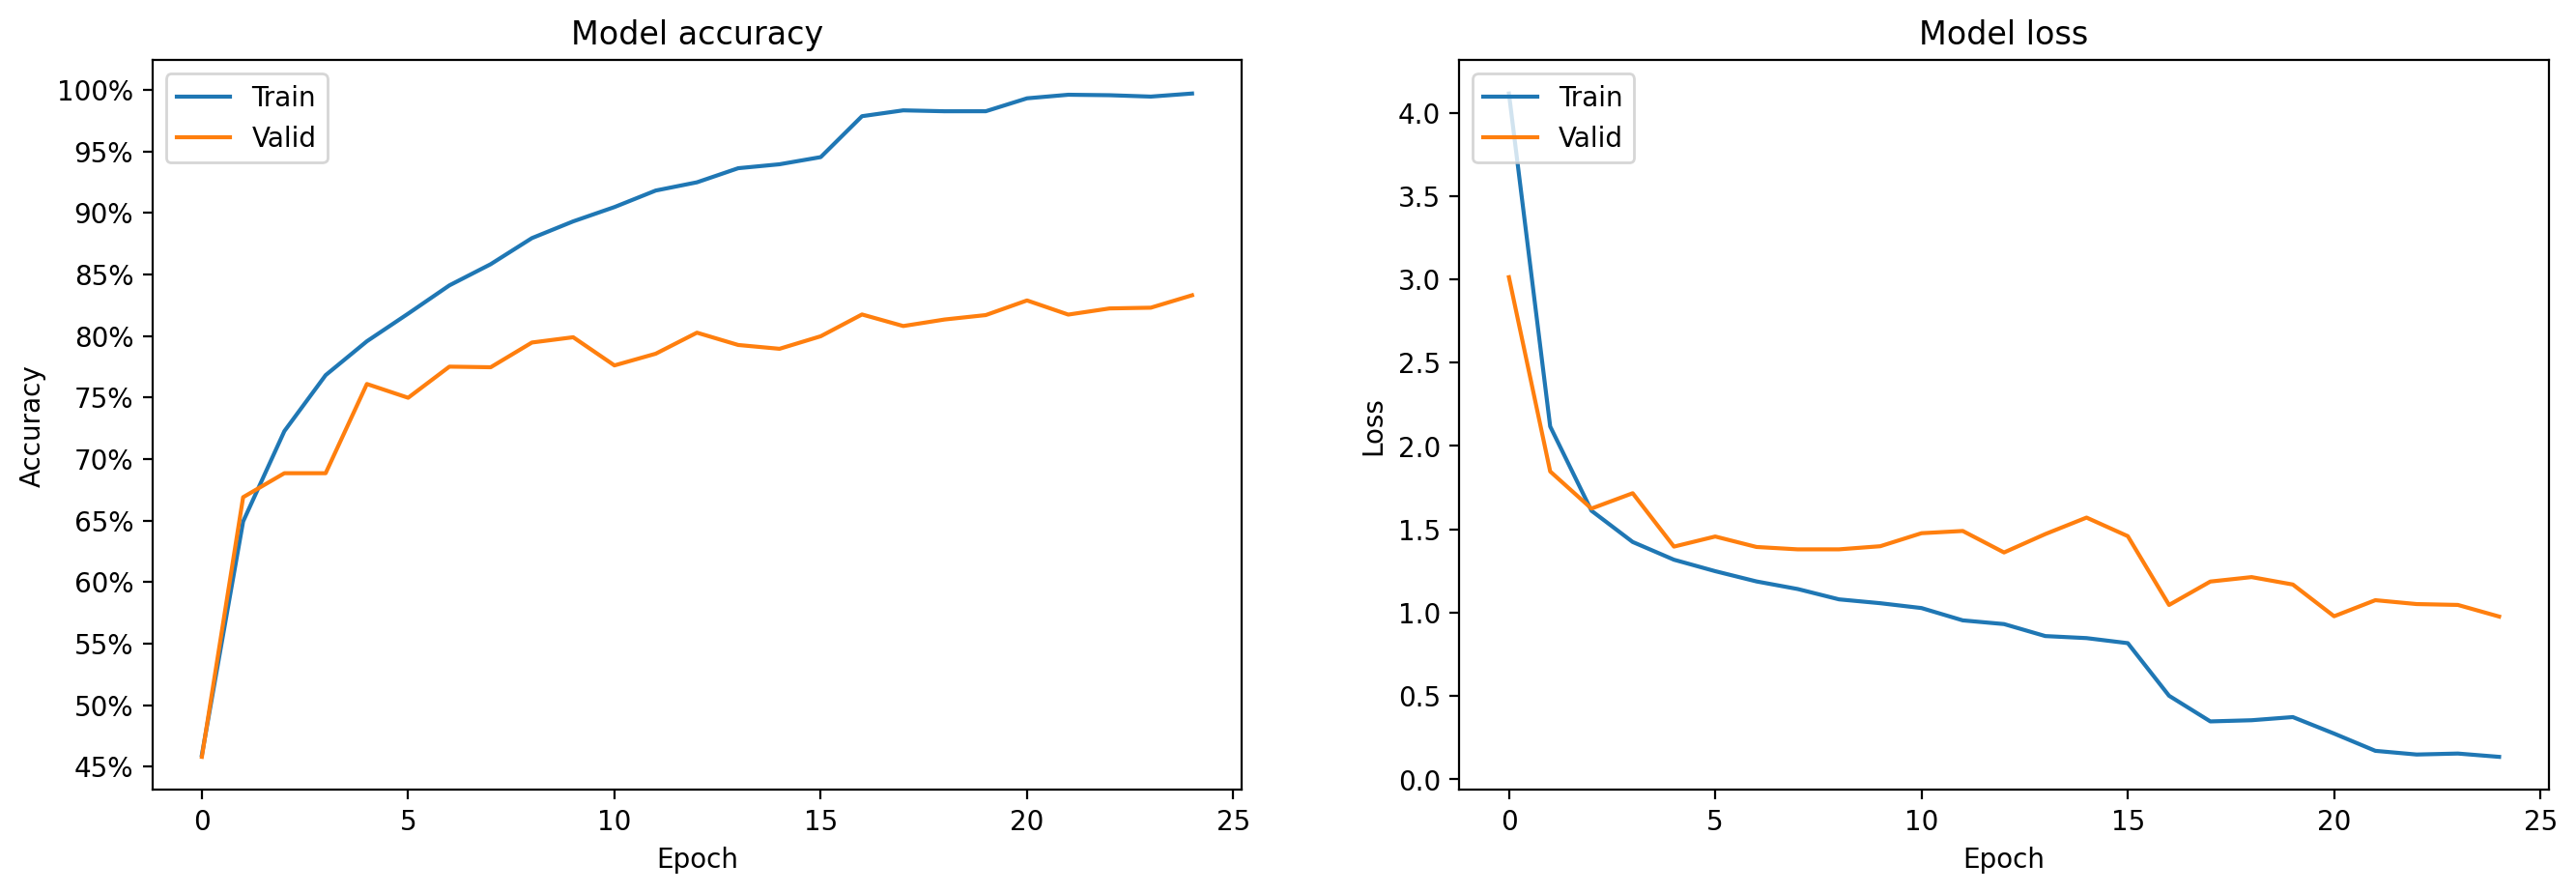

In [6]:
xticks = list(range(0,26,5))
yticks = [_/20 for _ in range(0,21)]
yticklabels = [f'{_:.0%}' for _ in yticks]
plt.figure(figsize=(16,5), dpi=200)

plt.subplot(1, 2, 1,
            title='Model accuracy',
            xticks=xticks, yticks=yticks,
            yticklabels=yticklabels,
            xlabel='Epoch', ylabel='Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Valid'], loc='upper left')

plt.subplot(1, 2, 2,
            title='Model loss',
            xticks=xticks,
            xlabel='Epoch', ylabel='Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## 預測新圖片，輸入影像前處理要與訓練時相同
#### ((X-mean)/(std+1e-7) ):這裡的mean跟std是訓練集的
## 維度如下方示範

In [7]:
input_example=(np.zeros(shape=(1,32,32,3))-mean_train)/(std_train+1e-7) 
classifier.predict(input_example)

array([[3.3510244e-03, 2.0218389e-05, 1.4945316e-03, 9.9068427e-01,
        1.3526055e-03, 2.8473423e-05, 1.9502101e-03, 3.0173127e-05,
        1.0165077e-03, 7.2064526e-05]], dtype=float32)